# Домашнее задание

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#from sklearn.feature_extraction.text import TfidfVectorizer
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df = pd.read_csv("C:\\Users\\tanbe\\Desktop\\Churn_Modelling.csv")
df

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


Есть как категориальные, так и вещественные признаки. Поле CustomerId нужно будет удалить. 

Посмотрим на распределение классов:

In [3]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

Не самое плохое распределение (1 к 4)

Давайте построим модель. Сразу же будем работать с использованием sklearn pipeline

In [4]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=0)

- Категориальные признаки закодируем с помощью OneHotEncoding
- Вещественные оставим пока как есть

In [5]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [6]:
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


Зададим списки признаков

In [7]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

Посмотрим как это работает на примере отдельного категориального признака - Gender

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

gender = Pipeline([
                ('selector', FeatureSelector(column='Gender')),
                ('ohe', OHEEncoder(key='Gender'))
            ])
gender.fit(X_train)
gender.transform(X_test).head(3)

,Gender_Female,Gender_Male
9394,1,0
898,1,0
2398,1,0


Теперь нам нужно под каждый признак создать трансформер и объединить их в список (сделаем это в цикле, чтобы не мучиться)

In [9]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col))
            ])
    final_transformers.append((cont_col, cont_transformer))

Объединим все это в единый пайплайн

In [10]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

Теперь у нас есть пайплайн, который готовит признаки для моделирования.

Добавим модель

In [11]:
from sklearn.ensemble import RandomForestClassifier

pipeline = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 42)),
])

Обучим модель

In [12]:
#обучим наш пайплайн
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [13]:
#наши прогнозы для тестовой выборки
preds = pipeline.predict_proba(X_test)[:, 1]
preds[:10]

array([0.37, 0.26, 0.16, 0.02, 0.02, 0.67, 0.04, 0.12, 0.15, 0.75])

Также нам нужно от вероятностей перейти к меткам классов. Для этого нужно подобрать порог, после которого мы считаем, что объект можно отнести к классу 1 (если вероятность больше порога - размечаем объект как класс 1, если нет - класс 0)

In [14]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

In [15]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.380000, F-Score=0.641, Precision=0.653, Recall=0.629


In [16]:
comp = pd.DataFrame(columns=['model', 'Best Threshold', 'F_score', 'Precision', 'Recall'])
comp = comp.append({'model': 'RandomForestClassifier', 'Best Threshold': thresholds[ix], 'F_score': fscore[ix], 'Precision': precision[ix],\
                'Recall': recall[ix]}, ignore_index=True)
comp

,model,Best Threshold,F_score,Precision,Recall
0,RandomForestClassifier,0.38,0.640641,0.653061,0.628684


__1. Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)__

__XGBoost__

In [17]:
import xgboost as xgb

In [18]:
xgb_pipeline = Pipeline([
    ('features', feats),
    ('classifier', xgb.XGBClassifier(random_state = 42, use_label_encoder=False, objective='binary:logistic')),
])

In [19]:
xgb_pipeline.fit(X_train, y_train)

[10:11:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [20]:
preds = xgb_pipeline.predict_proba(X_test)[:, 1]
preds[:10]

array([0.47611395, 0.23087966, 0.0737261 , 0.03141731, 0.02561874,
       0.9679959 , 0.06951059, 0.2885457 , 0.11367497, 0.4902508 ],
      dtype=float32)

In [21]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.373318, F-Score=0.626, Precision=0.619, Recall=0.633


In [22]:
comp = comp.append({'model': 'XGBoost', 'Best Threshold': thresholds[ix], 'F_score': fscore[ix], 'Precision': precision[ix],\
                'Recall': recall[ix]}, ignore_index=True)
comp

,model,Best Threshold,F_score,Precision,Recall
0,RandomForestClassifier,0.380000,0.640641,0.653061,0.628684
1,XGBoost,0.373318,0.625850,0.619231,0.632613


__Логистическая регрессия__

In [26]:
from sklearn.preprocessing import StandardScaler

In [27]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    final_transformers.append((cont_col, cont_transformer))

In [28]:
log_reg_pipeline = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state = 42)),
])

In [29]:
log_reg_pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [30]:
preds = log_reg_pipeline.predict_proba(X_test)[:, 1]
preds[:10]

array([0.22390104, 0.33707751, 0.18489566, 0.09197292, 0.18590078,
       0.40873004, 0.18821398, 0.18360246, 0.43551361, 0.70866171])

In [31]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall + 0.00000000000001)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.199920, F-Score=0.411, Precision=0.296, Recall=0.676


In [32]:
comp = comp.append({'model': 'LogReg', 'Best Threshold': thresholds[ix], 'F_score': fscore[ix], 'Precision': precision[ix],\
                'Recall': recall[ix]}, ignore_index=True)
comp

,model,Best Threshold,F_score,Precision,Recall
0,RandomForestClassifier,0.380000,0.640641,0.653061,0.628684
1,XGBoost,0.373318,0.625850,0.619231,0.632613
2,LogReg,0.199920,0.411483,0.295787,0.675835


__2. Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)__

Между бустингом и логистической регрессией лучшей моделью стал бустинг. Наиболее подходящая DS-метрика - Recall, так как нам нужно вычленить максимум собирающихся уйти пользователей.

__3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты.__

In [23]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)


    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

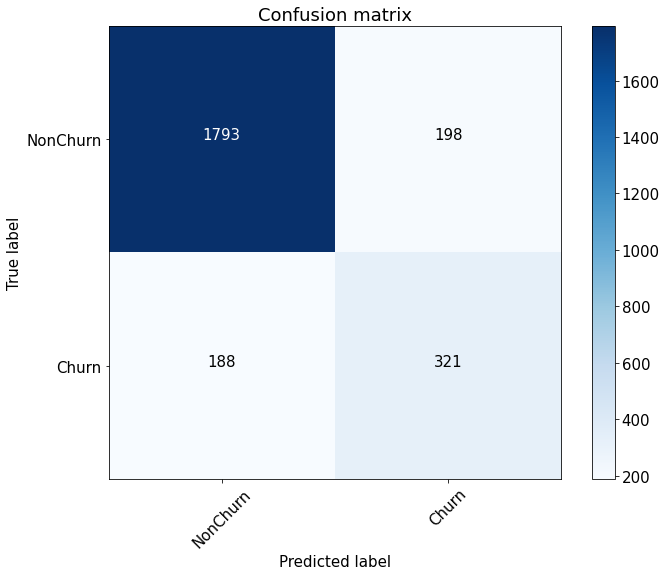

In [24]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [25]:
ec_eff = (cnf_matrix[1, 1] * 2) - (sum(cnf_matrix[:, 1]) * 1)
print(f'Экономическая эффективность: {ec_eff}$')

Экономическая эффективность: 123$
